# Equality- Data cleaning and pre-processing

In [2]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [3]:
raw_data = pd.read_csv('cba_clauses_dump_13032020 - cba_clauses_dump_13032020.csv')
print('Index in the raw data: ', raw_data.columns)
print('number of unique cba ids: ', len(raw_data.cba_id.unique()))

Index in the raw data:  Index(['cba_id', 'country', 'countrycode', 'locale', 'bind', 'label',
       'clause'],
      dtype='object')
number of unique cba ids:  1247


# Equality Scores DataFrame

How the Equality Scoring Formula be bulit:

Scoring from these four elements
1. Mention of procedure/grievance (we need to translate search words to other languages)

2. Gender equality
gender
eqpromotion
eqtraining
eqofficer
equalityexcludedtrigger & equalityexcludedtxt
equalitydifferenttrigger & equalitydifferenttxt
equalitymonitoring
equalityotherclause
equalitytxt
violenceleave
support_disabilities
3. Discrimination
discrimination
eqpay
4. Sexual harrasment
sexualhar

Above in each element, factors(triggers) taken into consideration are addressed




In [4]:
#Total number of ids: 1247 
#Equality related ids: 584 
GenderEquality = pd.read_csv('GenderEquality2.csv')
GenderEquality.bind.unique()
GenderEquality.describe(include='all')

,id,country,locale,bind,text,sector
count,1910,1910,1910,1910,1910,1910
unique,584,49,51,17,1504,59
top,#NAME?,indonesia,BA_ID,discrimination,#NAME?,"400,,,,"
freq,16,614,614,369,15,582


In [5]:
# 1. Mention of procedure/grievance (we need to translate search words to other languages)

# findString function showing the exsistance of particular terms
def findString(t):
    terms = ['processing','process','procedure','procedures','grievance','grievances',
            'procedimiento','queja','reclamo',
            'procedura','skarga','zażalenie',
            'διαδικασία','αιτίαση', 'αιτιάσεις','καταγγελία',
            '过程','申诉','诉状',
            'procedura','lamentela','denuncia',
            'procedure','grief','klacht',
            'menetely','valitus', 'epäkohta','kantelu',
            'procedimento', 'queixa', 'reclamação',
            'procédure','grief','plainte',
            'procedura','postup','stížnost','reklamace',
            'postup','sťažnosť','sťažovanie sa',
            'Prosedür','Yöntem','Şikayet','Şikayet'
            ]
    num_of_mention = 0
    for i in terms:
        if t.lower().find(i) > -1:
            num_of_mention += 1
    if num_of_mention > 0:
        return 1
    else:
        return 0
    
# applying findString fuction to each gender equality related clauses
GenderEquality['procedure'] = GenderEquality['text'].apply(findString)

In [6]:
print('Number of text mentioned the related terms: ',sum(GenderEquality.procedure))

Number of text mentioned the related terms:  149


In [7]:
# 2. Gender equality
# related triggers: gender,eqpromotion, eqtraining, eqofficer, equalityexcludedtrigger, equalityexcludedtxt, equalitydifferenttrigger, equalitydifferenttxt, equalitymonitoring, equalityotherclause, equalitytxt, violenceleave

# 3. Discrimination
# related triggers: discrimination, eqpay, support_disabilities

# 4. Sexual harrasment
#related trigger: sexualhar


# Classify each item to either Gender equality (GE) , Discrimination (Discrim) or Sexual harrasment (SH)
def classifyBind(bind):
    GE_list = ['equalitymonitoring','violence','equalitydifferenttrigger','equalityotherclause','eqpromotion','equalityexcludedtrigger','gender','eqtraining','GENEQ_trigger','eqofficer','violenceleave','equalityexcludedtxt','equalitytxt','support_disabilities']
    Discrim_list = ['discrimination','eqpay']
    SH_list = ['sexualhar']
    
    if bind in Discrim_list:
        return 'Discrim'
    elif bind in SH_list:
        return 'SH'
    elif bind in GE_list:
        return 'GE'
    
GenderEquality['bind_catagories'] = GenderEquality['bind'].apply(classifyBind)       

In [8]:
def binaryGE(bind):
    if bind == 'GE':
        return 1
    else:
        return 0

def binaryDiscrim(bind):
    if bind == 'Discrim':
        return 1
    else:
        return 0

def binarySH(bind):
    if bind == 'SH':
        return 1
    else:
        return 0

GenderEquality['GE'] = GenderEquality['bind_catagories'].apply(binaryGE)
GenderEquality['SH'] = GenderEquality['bind_catagories'].apply(binarySH)
GenderEquality['Discrim'] = GenderEquality['bind_catagories'].apply(binaryDiscrim)


In [9]:
GenderEquality_binary_score=GenderEquality.copy()
# GenderEquality_binary_score.to_csv('./binary_score_for_each_component.csv',index=True)

In [10]:
# aggregate the score by id and bind catagories
grouped = GenderEquality.groupby(['id'], sort = False)
initial_score =grouped.sum()
# drop one row with unclear id -- #NAME?
initial_score=initial_score.drop('#NAME?')

print(initial_score)
print(initial_score.describe())
# initial_score.to_csv('./initial_score.csv',index = True)

                                                    procedure  GE  SH  Discrim
id                                                                            
ccnl-impiegati-amministrativi-agenzie-generali-...          0   2   1        0
collective-agreement-between-financial-business...          0   5   1        1
collective-agreement-between-adamus-resources-l...          0   4   1        1
collective-agreement-between-financial-business...          0   2   1        0
collective-agreement-between-satellite-trans-lt...          0   0   1        1
...                                                       ...  ..  ..      ...
overenskomst-ba_sbl_hk                                      0   1   0        2
vvs-overenskomsterne_2014-2017                              0   1   0        1
recognition-and-procedural-agreement-between-cb...          0   0   0        1
ccnl-dipendenti-delle-aziende-societ-ed-enti-pu...          1   6   1        1
cao-bakkersbedrijf-2019-2020                        

In [11]:
# Normalizing the scores

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
#scaler2 = MinMaxScaler(feature_range=(0, 5))
scaled_score=initial_score.copy()

scaled_procedure = scaler.fit_transform(np.array(scaled_score.procedure.values.tolist()).reshape(-1,1))
scaled_GE = scaler.fit_transform(np.array(scaled_score.GE.values.tolist()).reshape(-1,1))
scaled_SH = scaler.fit_transform(np.array(scaled_score.SH.values.tolist()).reshape(-1,1))
scaled_Discrim = scaler.fit_transform(np.array(scaled_score.Discrim.values.tolist()).reshape(-1,1))

scaled_score.procedure = scaled_procedure.reshape(583,)
scaled_score.GE = scaled_GE.reshape(583,)
scaled_score.SH = scaled_SH.reshape(583,)
scaled_score.Discrim = scaled_Discrim.reshape(583,)

# Calculating the total score for gender equality (approach 1 ： averaged by 4 general factors)
total = scaled_score.mean(1)
scaled_total = scaler.fit_transform(np.array(total.values.tolist()).reshape(-1,1))
scaled_score['total'] = scaled_total.reshape(583,)

print(scaled_score.describe())

scaled_score.to_csv('./gender_equality_score.csv',index=True)

        procedure          GE         SH     Discrim       total
count  583.000000  583.000000  583.00000  583.000000  583.000000
mean     1.204460    1.881265    2.55060    1.878216    1.933475
std      0.527375    0.707261    1.95053    0.639955    0.814671
min      1.000000    1.000000    1.00000    1.000000    1.000000
25%      1.000000    1.444444    1.00000    1.000000    1.287162
50%      1.000000    1.888889    1.00000    2.000000    1.574324
75%      1.000000    2.333333    5.00000    2.000000    2.655405
max      5.000000    5.000000    5.00000    5.000000    5.000000


# Data Visualization

### Summary

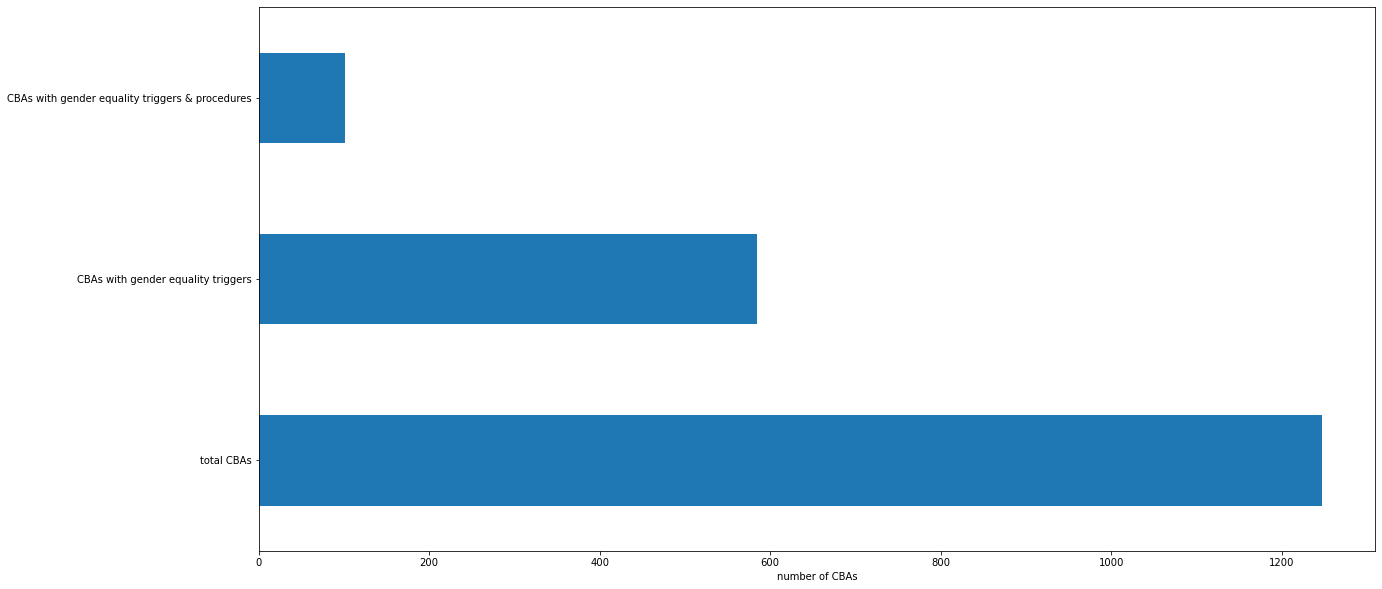

In [13]:
total_unique_cba_ids = len(raw_data.cba_id.unique())
genderequality_unique_cba_ids = 584
genderequality_mentioned_procedures = len(initial_score.loc[initial_score['procedure'] > 0])

number_of_cbas=pd.DataFrame([total_unique_cba_ids,genderequality_unique_cba_ids,genderequality_mentioned_procedures],index=['total CBAs','CBAs with gender equality triggers','CBAs with gender equality triggers & procedures'])
number_of_cbas.plot.barh(legend=None,figsize=(20,10))
plt.xlabel("number of CBAs")
plt.show()

In [27]:
#final gender equality score table with country and language
score_with_country = scaled_score.copy()
score_with_country.reset_index(level = 0, inplace = True)
score_with_country = score_with_country.merge(GenderEquality.iloc[:,0:3], on = 'id', how = 'left').drop_duplicates(['id'])
score_with_country.to_csv('./score_with_country.csv',index=False)

### number of CBAs by country

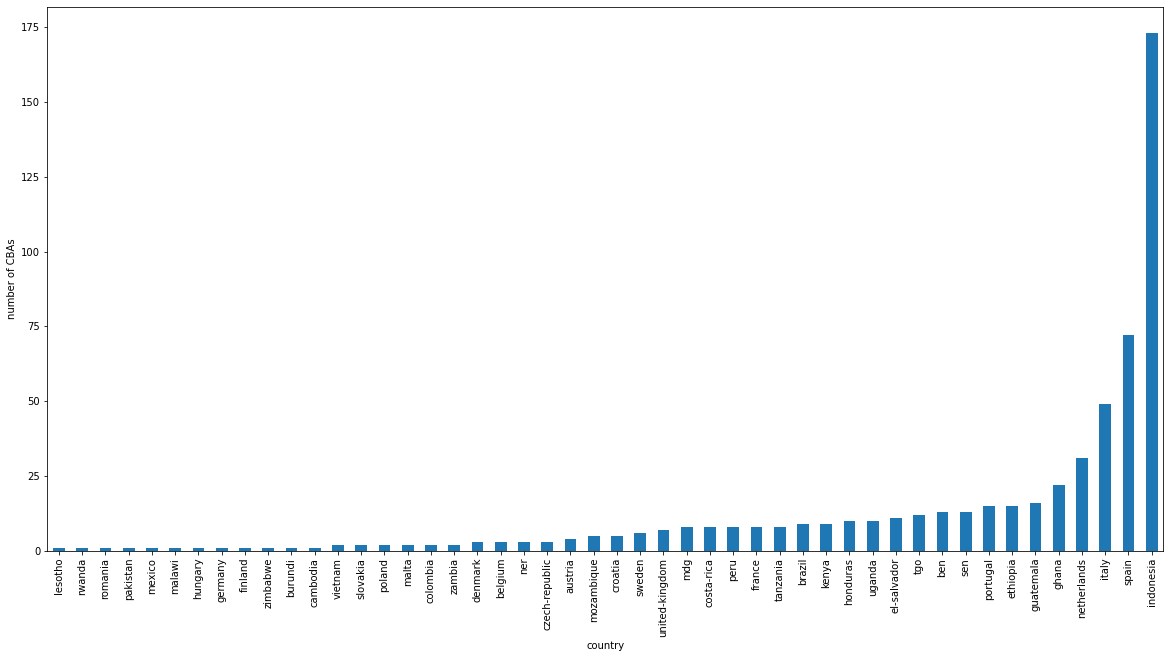

In [17]:
grouped_by_country=score_with_country.groupby('country')['id'].count().sort_values()
grouped_by_country.plot(kind='bar',figsize=(20,10))
plt.ylabel("number of CBAs")
plt.show()

In [19]:
score_averaged_by_country=score_with_country.groupby('country').mean()
score_averaged_by_country.shape

(48, 5)

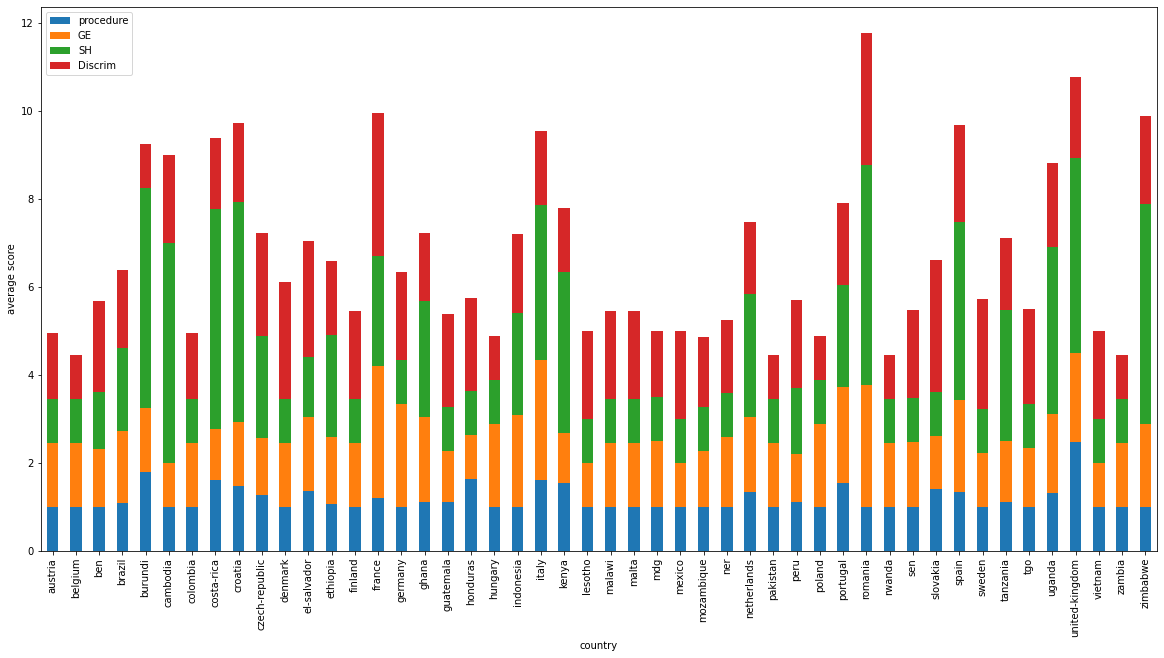

In [22]:
score_averaged_by_country.plot( y=["procedure", "GE", "SH","Discrim"], kind="bar", stacked=True, figsize=(20,10))
plt.ylabel('average score')
plt.legend(loc='upper left')
plt.show()

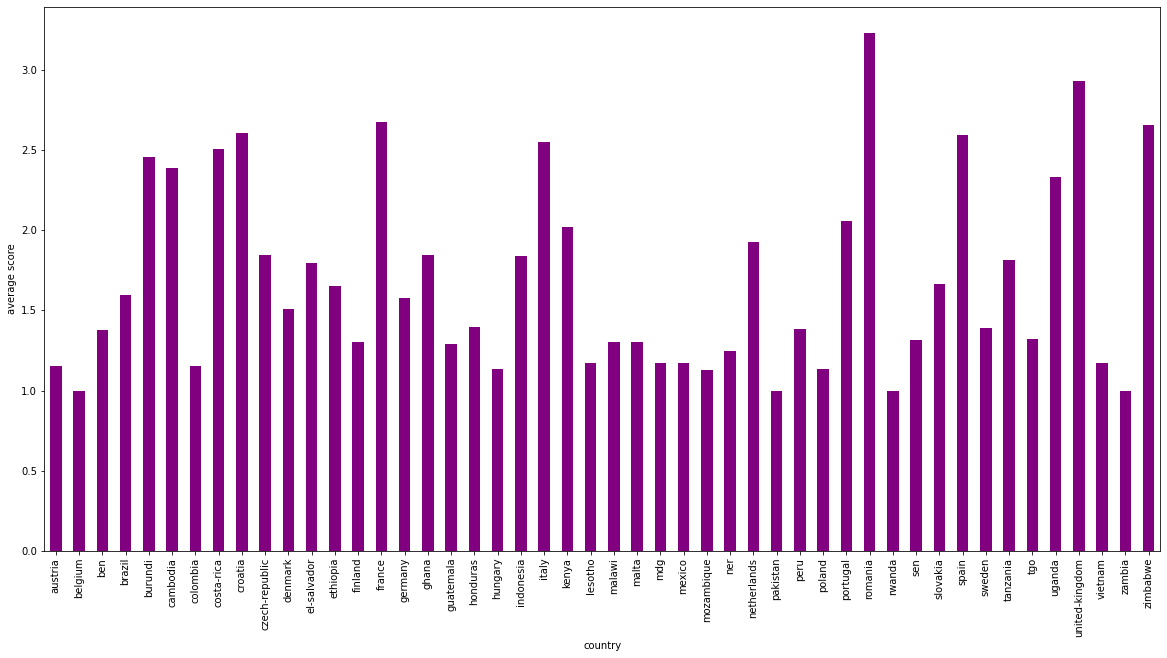

In [21]:
score_averaged_by_country.plot( y=["total"], kind="bar",legend=None, color='purple',figsize=(20,10))
plt.ylabel('average score')
plt.show()

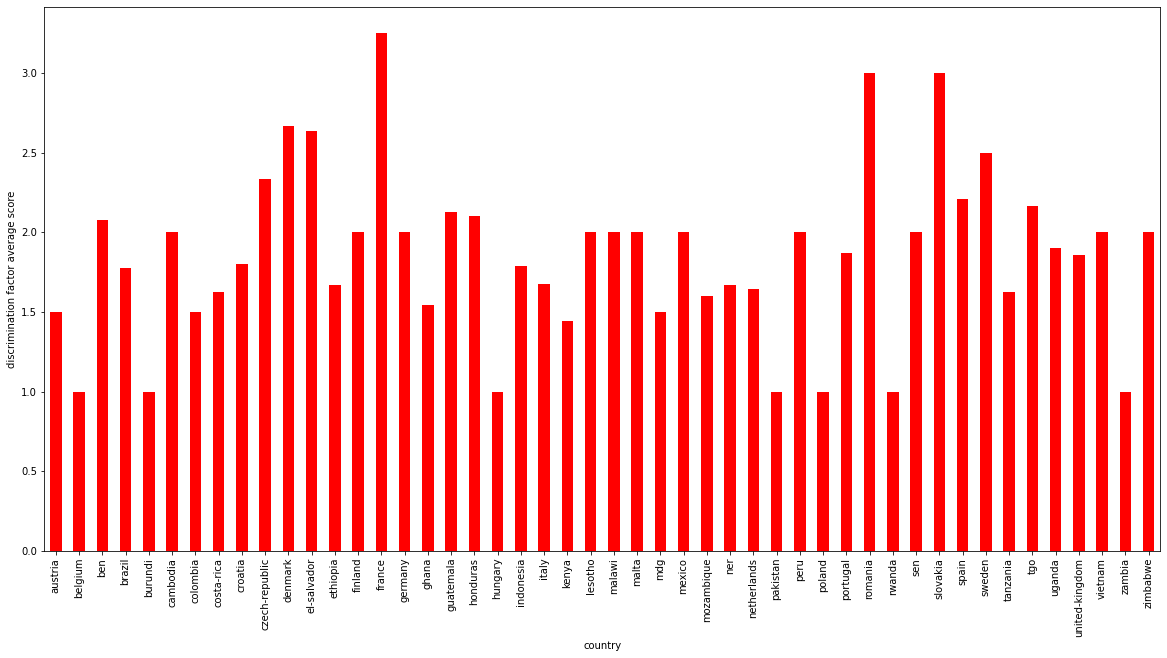

In [23]:
score_averaged_by_country.plot( y=["Discrim"], kind="bar",legend=None, color='red',figsize=(20,10))
plt.ylabel('discrimination factor average score')
plt.show()

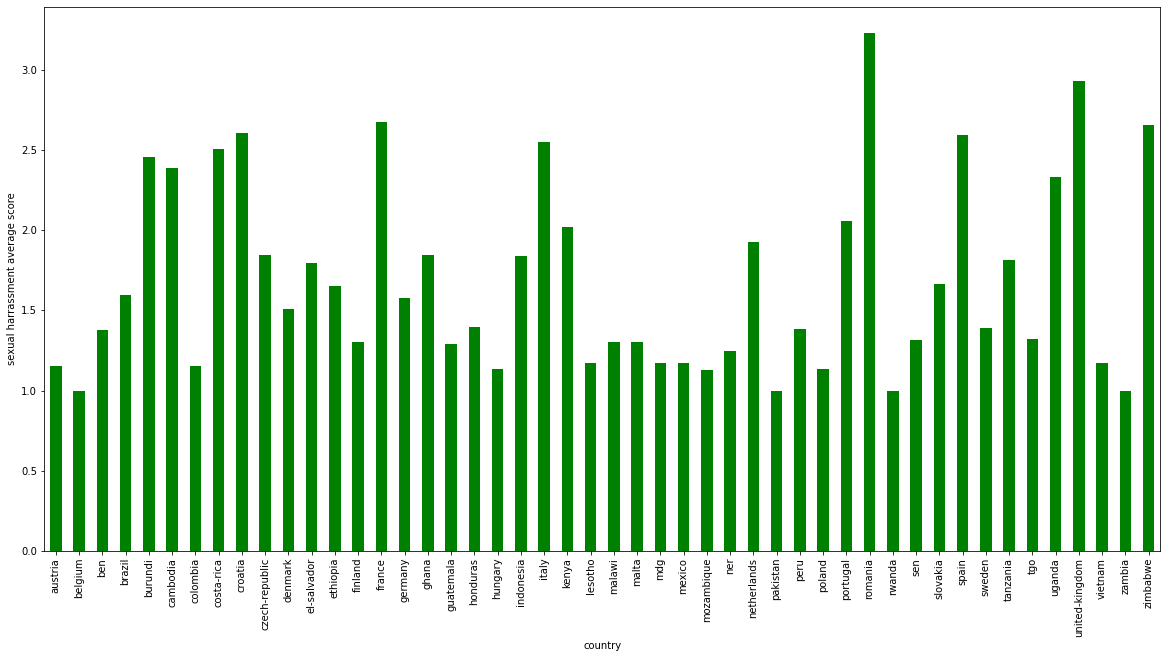

In [24]:
score_averaged_by_country.plot( y=["total"], kind="bar",legend=None, color='green',figsize=(20,10))
plt.ylabel('sexual harrassment average score')
plt.show()

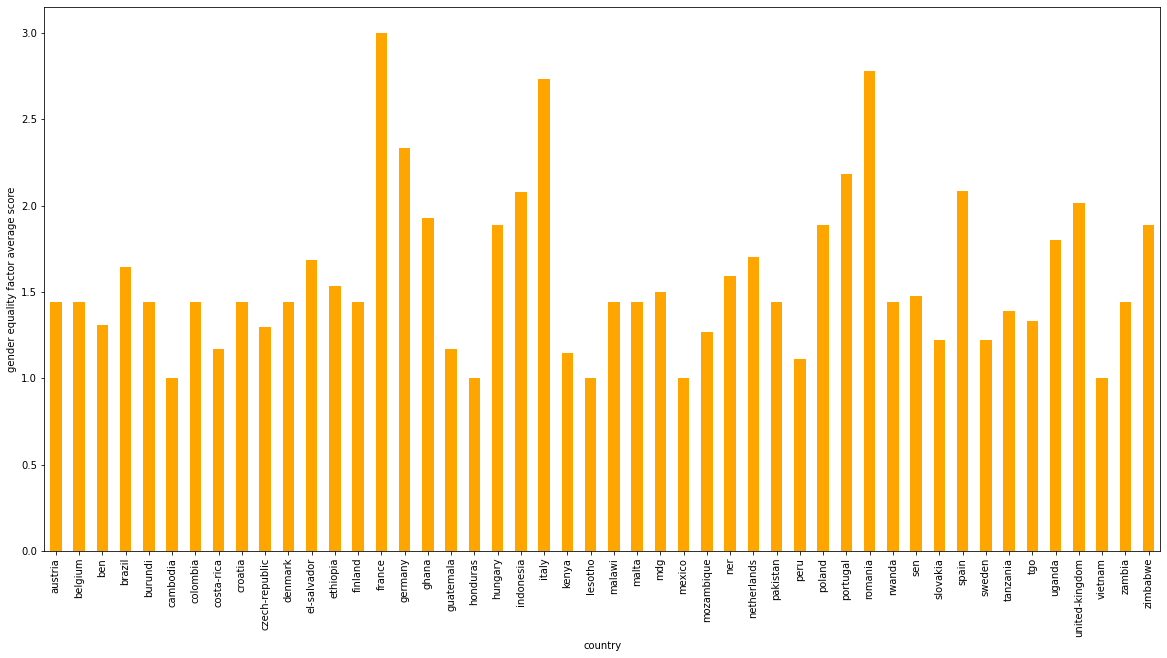

In [25]:
score_averaged_by_country.plot( y=["GE"], kind="bar",legend=None,color='orange',figsize=(20,10))
plt.ylabel('gender equality factor average score')
plt.show()

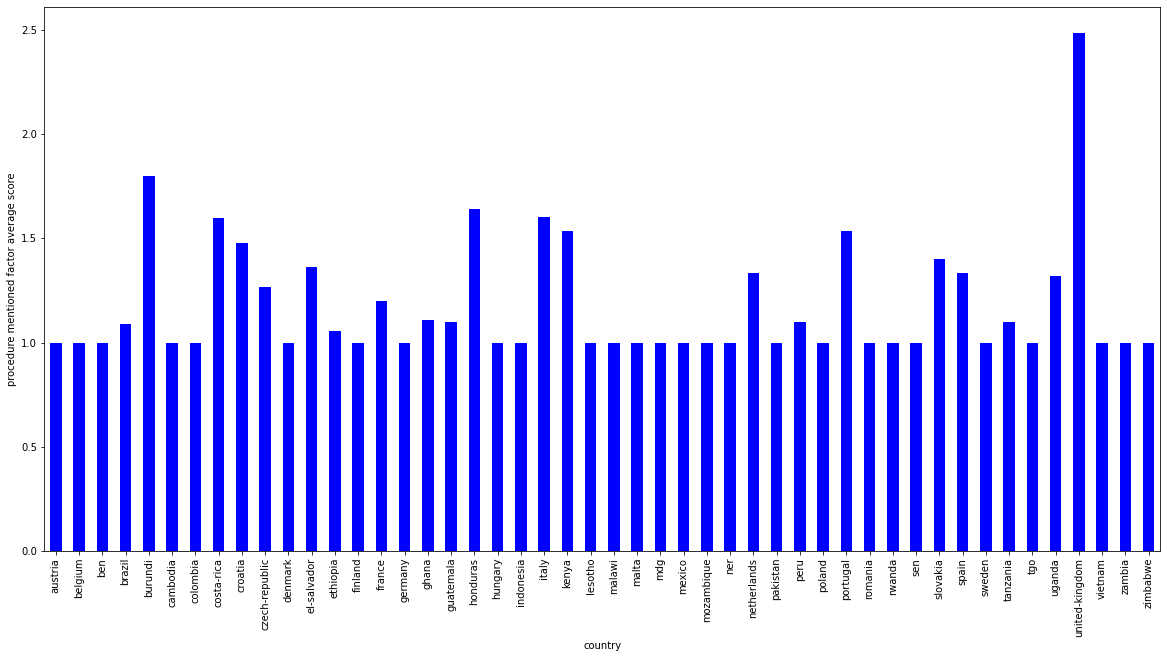

In [26]:
score_averaged_by_country.plot( y=["procedure"], kind="bar",legend=None, color='blue',figsize=(20,10))
plt.ylabel('procedure mentioned factor average score')
plt.show()

### WordCloud
can only apply to CBAs in English

In [82]:
print(GenderEquality.locale.value_counts())

BA_ID    614
ES_ES    318
IT_IT    255
NL_NL     83
EN_GH     67
FR_FR     57
PT_PT     53
ES_SV     36
EN_UG     34
EN_GB     28
FR_SN     27
FR_BJ     24
ES_GT     24
FR_TG     23
PT_BR     22
AM_ET     20
EN_ET     16
ES_CR     16
EN_TZ     16
HR_HR     14
FR_MG     13
EN_KE     13
SV_SE     12
ES_PE     11
ES_HN     11
KM_KH     11
DA_DK      8
RO_RO      7
CS_CZ      7
FR_NE      6
PT_MZ      6
DE_AT      6
SK_SK      5
PT-PT      5
DE_DE      4
PL_PL      4
EN_ZW      4
HU_HU      4
MT_MT      4
ES_CO      3
FR_BE      3
FI_FI      2
EN_ZM      2
BG_BG      2
FR_BI      2
EN_MW      2
VI_VN      2
EN_RW      1
EN_PK      1
ES_MX      1
EN_LS      1
Name: locale, dtype: int64


In [83]:
text_ghana=GenderEquality.loc[GenderEquality['country']=='ghana'].text
text_uk=GenderEquality.loc[GenderEquality['country']=='united-kingdom'].text
text_tanzania=GenderEquality.loc[GenderEquality['country']=='tanzania'].text

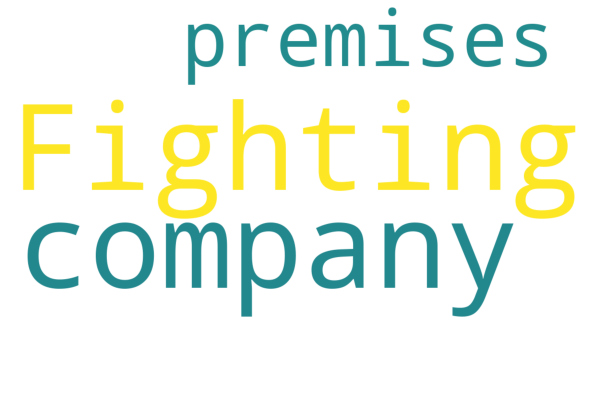

In [84]:
# WordCloud
   
stopwords = set(STOPWORDS)
for val in text_ghana:
    val = str(val)
    tokens = val.split()
text = ' '.join(tokens)
    
wordcloud = WordCloud(width = 1200, height = 800, 
            background_color ='white', 
            stopwords = stopwords).generate(text)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 
    


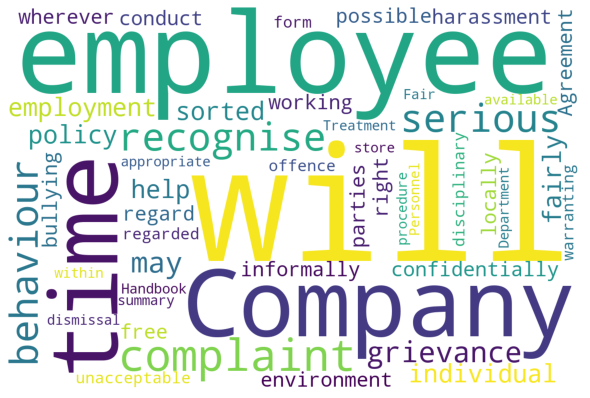

In [85]:
# WordCloud
for val in text_uk:
    val = str(val)
    tokens = val.split()
text = ' '.join(tokens)
    
wordcloud = WordCloud(width = 1200, height = 800, 
            background_color ='white', 
            stopwords = stopwords).generate(text)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 
    

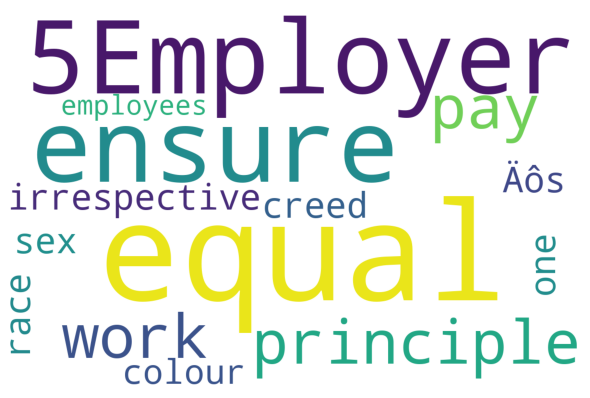

In [86]:
# WordCloud
for val in text_tanzania:
    val = str(val)
    tokens = val.split()
text = ' '.join(tokens)
    
wordcloud = WordCloud(width = 1200, height = 800, 
            background_color ='white', 
            stopwords = stopwords).generate(text)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 